Импорты и настройки

In [272]:
# import sys
# sys.path.insert(0, 'C://Users//Adminn//Downloads')
# from tqdm import tqdm
# import datetime as dtime
from scipy.stats import norm
import scipy.stats as stats
from statsmodels. stats.multicomp import pairwise_tukeyhsd

import random
import math
from glob import glob
from pprint import pprint
from time import time
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [273]:
# cd Telegram Desktop

Парсинг данных и очистка

In [274]:
df = pd.read_csv('csv/data_test.csv')

df.date = pd.to_datetime(df.date)
df['click_rate'] = df['clicks']/df['impressions']
df= df[(df['clicks']>0) | (df['impressions']>100)]
df['campaign_name'] = df['campaign_name'].str.lower()
df = df.drop('campaign_id',axis=1)
df= df.drop(df.loc[df['impressions']<df['clicks']].index) # 1 клик при 0 показов

Выделим отдельные капании по наименованию препарата и ЦА. Переделал так, чтобы вся инфа лежала в изначальном датафрейме

In [275]:
df.loc[(df.campaign_name.str.contains('dexonal')) | (df.campaign_name.str.contains('дексонал')),'drug_name'] = 'dexonal'
df.loc[(df.campaign_name.str.contains('диклофенак')) | (df.campaign_name.str.contains('diclofena')),'drug_name'] = 'diclofenac_akos'
df.loc[(df.campaign_name.str.contains('maxilac')) | (df.campaign_name.str.contains('максилак')),'drug_name']  = 'maxilac'
df.loc[(df.campaign_name.str.contains('кагоцел')) | (df.campaign_name.str.contains('kagocel')),'drug_name']  = 'kagocel'
df.loc[(df.campaign_name.str.contains('венарус')) | (df.campaign_name.str.contains('venarus')),'drug_name']  = 'venarus'
df.loc[(df.campaign_name.str.contains('необутин')) | (df.campaign_name.str.contains('neobutin')),'drug_name']  = 'neobutin'
df.loc[(df.campaign_name.str.contains('эльмуцин')) | (df.campaign_name.str.contains('elmucin')),'drug_name']  = 'elmucin'
df.loc[(df.campaign_name.str.contains('парацитолгин')) | (df.campaign_name.str.contains('paracitolgin')),'drug_name']  = 'paracitolgin'
df.loc[(df.campaign_name.str.contains('акнауцер')) | (df.campaign_name.str.contains('aknaucer')),'drug_name']  = 'aknaucer'
df.loc[df['drug_name'].isna(),'drug_name'] = 'none'

In [276]:
df.groupby('drug_name').impressions.sum()

drug_name
aknaucer             349971
dexonal            13262653
diclofenac_akos    10812553
elmucin             2228468
kagocel             7143266
maxilac             2310167
neobutin            2595361
none                 885792
paracitolgin        1004031
venarus            14455175
Name: impressions, dtype: int64

Добавил переменную, обозначающую заданный формат рекламного контента. Там, где он не указан, скинул в Others

In [277]:
df.loc[(df.campaign_name.str.contains('carousel')) | (df.campaign_name.str.contains('carusel')),'adv_format']='carousel' 
df.loc[(df.campaign_name.str.contains('баннеры')) | (df.campaign_name.str.contains('banner')),'adv_format']='banner' 
df.loc[(df.campaign_name.str.contains('video')) | (df.campaign_name.str.contains('видео')),'adv_format']='video'
df.loc[(df.campaign_name.str.contains('multiformat')),'adv_format']='multiformat'
df.loc[~((df.campaign_name.str.contains('carousel')) | (df.campaign_name.str.contains('carusel')) |
      (df.campaign_name.str.contains('баннеры')) | (df.campaign_name.str.contains('banner')) |
      (df.campaign_name.str.contains('video')) | (df.campaign_name.str.contains('видео')) |
      (df.campaign_name.str.contains('multiformat'))),'adv_format']='others'

Сгруппирую по датам, и посмотрю клик рейт у разных форматов рекламы

In [278]:
df_grouped = df.groupby(['adv_format','date']).sum().reset_index() 
df_grouped['click_rate'] = df_grouped['clicks']/df_grouped['impressions']

Гипотеза: Разные форматы показа рекламы показывают разный cpc. Гипотеза подтверждается, однако на график я пока не знаю,
как можно будет это грамотно представить

In [279]:
tukey = pairwise_tukeyhsd(endog=df['click_rate'],
 groups=df['adv_format'].astype(str),
 alpha= 0.05 )
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
     banner    carousel  -0.0034    0.0 -0.0042 -0.0027   True
     banner multiformat  -0.0024    0.0 -0.0033 -0.0016   True
     banner      others  -0.0035    0.0 -0.0044 -0.0025   True
     banner       video   -0.002    0.0 -0.0027 -0.0012   True
   carousel multiformat    0.001 0.0268  0.0001  0.0019   True
   carousel      others     -0.0    1.0  -0.001  0.0009  False
   carousel       video   0.0015    0.0  0.0006  0.0023   True
multiformat      others   -0.001 0.0665 -0.0021     0.0  False
multiformat       video   0.0005 0.6577 -0.0005  0.0014  False
     others       video   0.0015 0.0006  0.0005  0.0025   True
--------------------------------------------------------------


На графике количества показов можно заметить, что обычным картинкам явно отдают предпочтение. Скорее всего отчасти из-за того, что они обеспечивают большее покрытие страницы

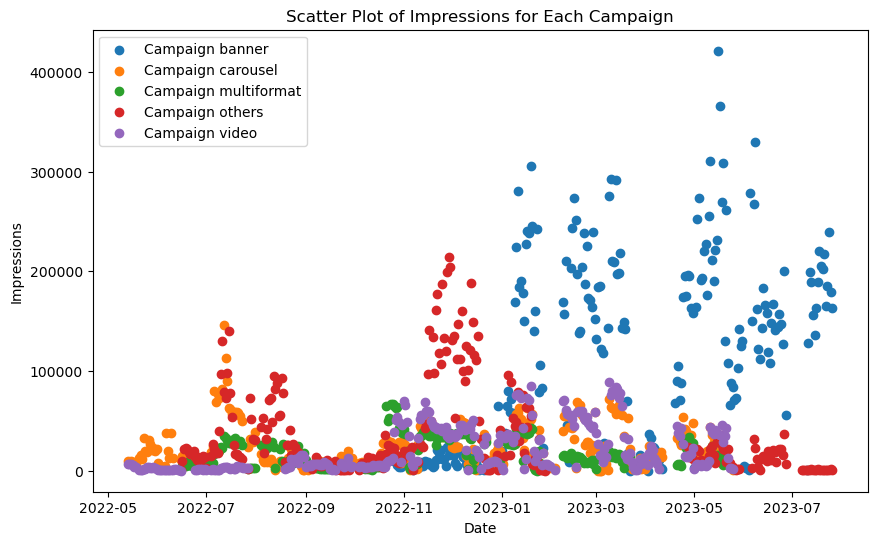

In [280]:
fig, ax = plt.subplots(figsize=(10, 6)) 


for adv_format, data in df_grouped.groupby('adv_format'):
    ax.scatter(data['date'], data['impressions'], label=f'Campaign {adv_format}')


ax.set_xlabel('Date')
ax.set_ylabel('Impressions')
ax.set_title('Scatter Plot of Impressions for Each Campaign')


ax.legend()


plt.show()

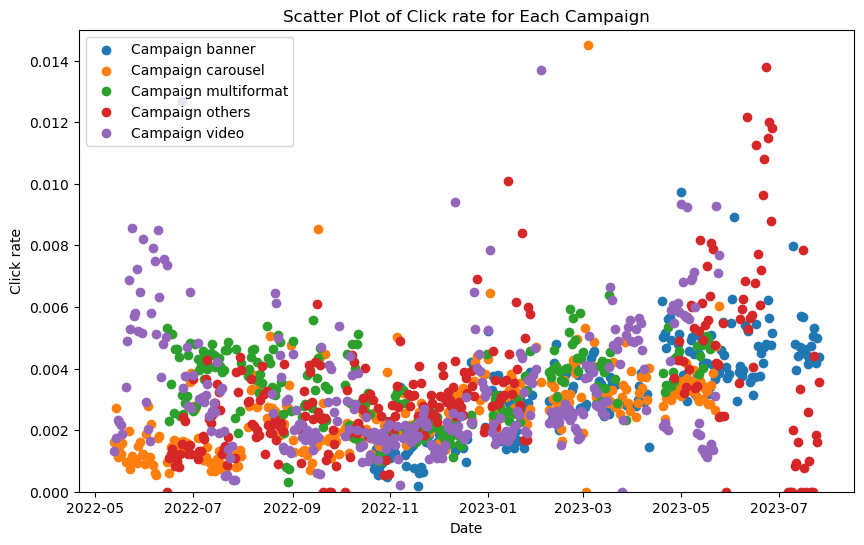

In [281]:
fig, ax = plt.subplots(figsize=(10, 6)) #Тут, к сожалению, пока не знаю как представить явно


for adv_format, data in df_grouped.groupby('adv_format'):
    ax.scatter(data['date'], data['click_rate'], label=f'Campaign {adv_format}')


ax.set_xlabel('Date')
ax.set_ylabel('Click rate')
ax.set_title('Scatter Plot of Click rate for Each Campaign')
ax.yaxis

ax.legend()
plt.ylim(0,0.015)

plt.show()

Сгруппируем по препарату и виду рекламы

In [282]:
grouped_sum = df.groupby(['drug_name','adv_format'])[['clicks', 'impressions']].sum().reset_index()
grouped_sum['click_rate'] = grouped_sum['clicks']/grouped_sum['impressions']

In [283]:
#Топ популярных/успешных препаратов

In [284]:
grouped_sum.loc[(grouped_sum.drug_name != 'none') & (grouped_sum.adv_format != 'others')].sort_values(by='click_rate',ascending=False).head(10)

,drug_name,adv_format,clicks,impressions,click_rate
24,neobutin,banner,5462,694443,0.007865
0,aknaucer,banner,228,35155,0.006486
12,elmucin,banner,5757,1158756,0.004968
6,dexonal,video,992,200887,0.004938
11,diclofenac_akos,video,1363,292984,0.004652
23,maxilac,video,1031,223785,0.004607
2,dexonal,banner,34801,7730627,0.004502
21,maxilac,banner,7026,1726928,0.004068
37,venarus,multiformat,2057,512887,0.004011
9,diclofenac_akos,multiformat,3957,991232,0.003992


In [285]:
grouped_sum.loc[(grouped_sum.drug_name != 'none') & (grouped_sum.adv_format != 'others')].sort_values(by='impressions',ascending=False).head(10)

,drug_name,adv_format,clicks,impressions,click_rate
2,dexonal,banner,34801,7730627,0.004502
7,diclofenac_akos,banner,18959,6580765,0.002881
35,venarus,banner,17554,6391849,0.002746
39,venarus,video,6559,4106513,0.001597
17,kagocel,carousel,6423,1836345,0.003498
21,maxilac,banner,7026,1726928,0.004068
16,kagocel,banner,2784,1620830,0.001718
18,kagocel,multiformat,2254,1455984,0.001548
3,dexonal,carousel,3287,1409649,0.002332
36,venarus,carousel,1393,1300370,0.001071


In [214]:
df.click_rate.corr(df.impressions)

-0.09893052610839927

<AxesSubplot:xlabel='click_rate', ylabel='impressions'>

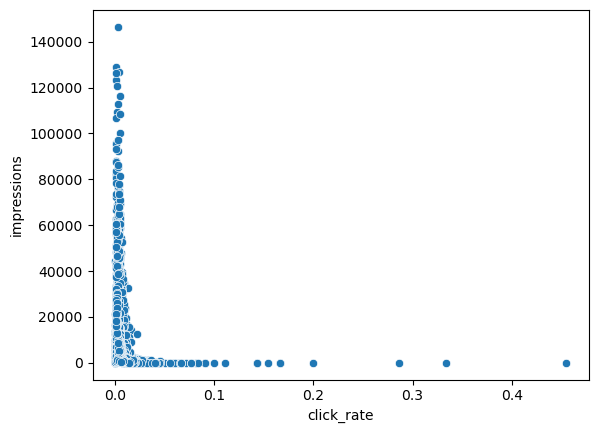

In [216]:
sns.scatterplot(x=df.click_rate,y=df.impressions)

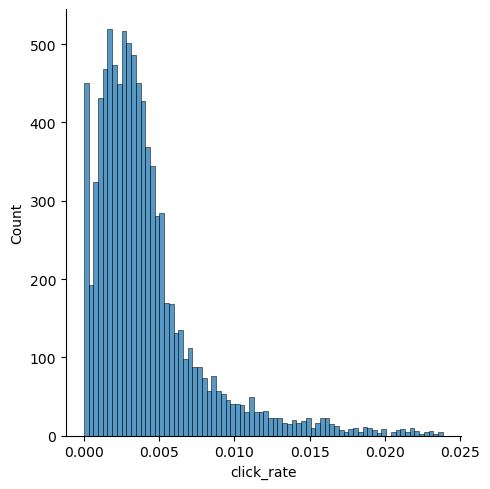

In [221]:
sns.displot(df[df['click_rate'] < 0.024]['click_rate'])

In [224]:
df.groupby('campaign_name').click_rate.mean().nlargest(10)

campaign_name
максилак | педиатры | баннеры | база бреффи                                               0.031414
диклофенак-акос | фармацевты | баннеры | база брефи                                       0.024201
необутин | педиатры | баннеры gif | база breffi                                           0.019365
ва039 | необутин | фармацевты | баннеры gif | база breffi                                 0.018334
необутин | педиатры | баннеры gif | база бфг                                              0.018096
ва036 | венарус | баннеры gif | сосудистые хирурги, флебологи | база breffi               0.015152
ва039 | необутин | фармацевты | баннеры gif | база бфг | костылев                         0.014467
св001 | необутин | гастро | баннеры gif | база breffi                                     0.013988
эльмуцин | фармацевты | баннеры | база брефи                                              0.013871
ва036 | венарус, венапрокт | баннеры gif | сосудистые хирурги, флебологи | база breffi    0.013

In [222]:
df

,platform,campaign_name,date,impressions,clicks,click_rate,adv_format
0,yandex direct,венарус | фармацевты | баннеры | база брефи,2023-04-23,35423,109,0.003077,banner
1,yandex direct,дексонал | фармацевты | баннеры | база брефи,2023-04-23,13654,159,0.011645,banner
2,yandex direct,венарус | фармацевты | баннеры | база бфг,2023-04-23,20100,58,0.002886,banner
3,yandex direct,дексонал | фармацевты | баннеры | база бфг,2023-04-23,3459,31,0.008962,banner
4,yandex direct,"ва036 | венарус, венапрокт | хирурги, проктоло...",2023-04-23,4061,29,0.007141,banner
...,...,...,...,...,...,...,...
91922,my target,diclofenac-akos_mt_cpc_multiformat_base_neurol...,2022-07-31,741,6,0.008097,multiformat
91936,my target,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,962,4,0.004158,multiformat
91937,my target,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,175,1,0.005714,multiformat
91938,my target,venarus_angiorus_mt_cpm_carousel_base_pharmacy...,2022-07-31,21167,27,0.001276,carousel


In [189]:
df.loc[16394]

platform                                             yandex direct
campaign_name    ва036 | венарус, венапрокт | баннеры gif | хир...
date                                           2023-06-15 00:00:00
impressions                                                      0
clicks                                                           1
click_rate                                                     inf
Name: 16394, dtype: object

In [165]:
carousel = carousel.groupby('date').sum().reset_index()
banners = banners.groupby('date').sum().reset_index()

videos = videos.groupby('date').sum().reset_index()
multiformat = multiformat.groupby('date').sum().reset_index()
others = others.groupby('date').sum().reset_index()

carousel['click_rate'] = carousel['clicks']/carousel['impressions']
banners['click_rate'] = banners['clicks']/banners['impressions']
videos['click_rate'] = videos['clicks']/videos['impressions']
multiformat['click_rate'] = multiformat['clicks']/multiformat['impressions']
others['click_rate'] = others['clicks']/others['impressions']

In [162]:
dexo_thera = add_campaign_numbers(dexo_thera)# Отделяем разные кампании
dexo_neuro = add_campaign_numbers(dexo_neuro)
dexo_surgeon = add_campaign_numbers(dexo_surgeon)
dexo_pharmacy = add_campaign_numbers(dexo_pharmacy)
dexo = add_campaign_numbers(dexo)

diclo_thera = add_campaign_numbers(diclo_thera)
diclo_pharmacy =add_campaign_numbers(diclo_pharmacy)
diclo_neuro =add_campaign_numbers(diclo_neuro)
diclo = add_campaign_numbers(diclo)

maxilac = add_campaign_numbers(maxilac)
maxilac_pediatr = add_campaign_numbers(maxilac_pediatr)
maxilac_pharmacy = add_campaign_numbers(maxilac_pharmacy)




In [164]:
data.loc[]

,date,impressions,clicks,click_rate
0,2022-05-13,9986,16,0.001602
1,2022-05-14,9179,25,0.002724
2,2022-05-15,9822,11,0.001120
3,2022-05-16,8934,13,0.001455
4,2022-05-17,8166,10,0.001225
...,...,...,...,...
324,2023-05-21,8331,32,0.003841
325,2023-05-22,9443,25,0.002647
326,2023-05-23,5061,24,0.004742
327,2023-05-24,4808,20,0.004160


In [106]:
carousel.mean(), banners.mean(), videos.mean(), multiformat.mean(),others.mean()

(impressions    24934.416413
 clicks            57.747720
 click_rate         0.002557
 dtype: float64,
 impressions    114391.609649
 clicks            411.302632
 click_rate          0.003858
 dtype: float64,
 impressions    18975.855769
 clicks            46.660256
 click_rate         0.003415
 dtype: float64,
 impressions    18647.453782
 clicks            52.970588
 click_rate         0.003684
 dtype: float64,
 impressions    9049.633749
 clicks           29.067114
 click_rate        0.003157
 dtype: float64)

In [119]:
def add_campaign_numbers(dataframe, window=10): #Окно между кампаниями я установил в 30 дней, тк это число показалось мне наиболее оптимальным
    dataframe = dataframe.sort_values('date')
    current_campaign = 0
    previous_date = None

    campaign_numbers = []

    for date in dataframe['date']:
        if previous_date is None or (date - previous_date).days > window:
            current_campaign += 1
        campaign_numbers.append(current_campaign)
        previous_date = date

    dataframe['campaign_number'] = campaign_numbers
    
    return dataframe

In [148]:
dexo_thera = dexo_thera.groupby('date').sum().reset_index()
dexo_pharmacy = dexo_pharmacy.groupby('date').sum().reset_index()
dexo_neuro = dexo_neuro.groupby('date').sum().reset_index()
dexo_surgeon = dexo_surgeon.groupby('date').sum().reset_index()
dexo = dexo.groupby('date').sum().reset_index()

diclo_neuro = diclo_neuro.groupby('date').sum().reset_index()
diclo_pharmacy = diclo_pharmacy.groupby('date').sum().reset_index()
diclo_thera = diclo_thera.groupby('date').sum().reset_index()
diclo = diclo.groupby('date').sum().reset_index()

maxilac = maxilac.groupby('date').sum().reset_index()
maxilac_pediatr = maxilac_pediatr.groupby('date').sum().reset_index()
maxilac_pharmacy = maxilac_pharmacy.groupby('date').sum().reset_index()

click_rate(dexo_thera)
click_rate(dexo_pharmacy)
click_rate(dexo_neuro)
click_rate(dexo_surgeon)
click_rate(dexo)

click_rate(diclo_neuro)
click_rate(diclo_pharmacy)
click_rate(diclo_thera)
click_rate(diclo)



,date,impressions,clicks,click_rate,campaign_number
0,2022-06-15,6432,12,0.001866,2
1,2022-06-16,9813,10,0.001019,2
2,2022-06-17,6080,8,0.001316,2
3,2022-06-18,5938,8,0.001347,2
4,2022-06-19,8639,8,0.000926,2
...,...,...,...,...,...
216,2023-05-15,15728,63,0.004006,12
217,2023-05-16,14262,69,0.004838,12
218,2023-05-17,12431,63,0.005068,12
219,2023-05-18,14228,70,0.004920,12


In [149]:
diclo_pharmacy

,date,impressions,clicks,click_rate,campaign_number
0,2022-06-15,6432,12,0.001866,2
1,2022-06-16,9813,10,0.001019,2
2,2022-06-17,6080,8,0.001316,2
3,2022-06-18,5938,8,0.001347,2
4,2022-06-19,8639,8,0.000926,2
...,...,...,...,...,...
172,2023-05-15,15728,63,0.004006,14
173,2023-05-16,14262,69,0.004838,14
174,2023-05-17,12431,63,0.005068,14
175,2023-05-18,14228,70,0.004920,14


In [155]:
diclo_pharmacy

,platform,campaign_name,date,impressions,clicks,click_rate,campaign_number
33378,my target,diclofenac-akos | mt_cpm_carousel_base_pharmac...,2022-06-15,5561,6,0.001079,1
33379,my target,diclofenac-akos_mt_cpc_multiformat_base_pharma...,2022-06-15,871,6,0.006889,1
34702,my target,diclofenac-akos_mt_cpc_multiformat_base_pharma...,2022-06-16,2560,4,0.001563,1
34701,my target,diclofenac-akos | mt_cpm_carousel_base_pharmac...,2022-06-16,7253,6,0.000827,1
35970,my target,diclofenac-akos | mt_cpm_carousel_base_pharmac...,2022-06-17,4516,3,0.000664,1
...,...,...,...,...,...,...,...
2191,my target,diclofenac-akos | multiformat | base_pharmacy_...,2023-05-17,7040,35,0.004972,7
3212,my target,diclofenac-akos | multiformat | base_pharmacy_bfg,2023-05-18,6373,35,0.005492,7
3191,my target,diclofenac-akos | multiformat | base_pharmacy_...,2023-05-18,7855,35,0.004456,7
4540,my target,diclofenac-akos | multiformat | base_pharmacy_bfg,2023-05-19,1642,13,0.007917,7


In [136]:
def click_rate(df):
    df['click_rate'] = df['clicks']/df['impressions']
    return df

In [24]:
dexo

,date,impressions,clicks,click_rate,campaign_number
0,2022-06-15,141,0,0.000000,1
1,2022-06-16,1293,0,0.000000,1
2,2022-06-17,18114,32,0.007672,1
3,2022-06-18,18731,36,0.009195,1
4,2022-06-19,17568,37,0.009260,1
...,...,...,...,...,...
319,2023-07-22,66547,333,0.033541,1
320,2023-07-23,76470,410,0.029297,1
321,2023-07-24,111993,456,0.028312,1
322,2023-07-25,73530,391,0.032387,1


Визуализация. Оптимизировал код Сергея

In [110]:
def plot(dataframe, column_name='clicks', rolling_window=1): # r_w = 1 == no rolling mean
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe = dataframe.sort_values(['campaign_number', 'date'])
    dataframe['rolled_mean'] = dataframe.groupby('campaign_number')[column_name].rolling(window=rolling_window, min_periods=rolling_window).mean().reset_index(level=0, drop=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for campaign_number, data in dataframe.groupby('campaign_number'):
        ax.scatter(data['date'], data['rolled_mean'], label=f'Campaign {campaign_number}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Impressions')
    ax.set_ylabel(f'Rolled Mean {column_name} (Window={rolling_window})')
    ax.set_title(f'Scatter Plot of {column_name} for {dataframe.campaign_name[0]}')

    ax.legend()
    plt.show()

<AxesSubplot:xlabel='date', ylabel='click_rate'>

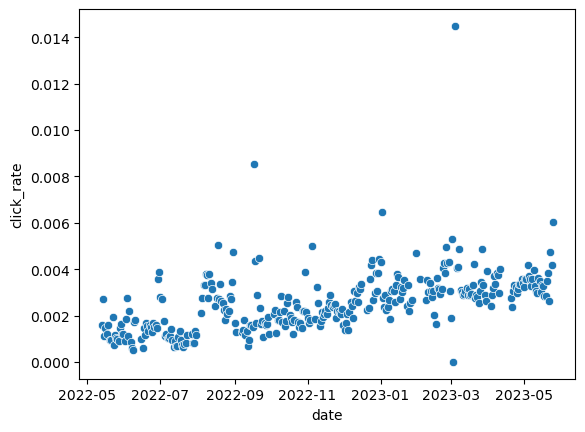

In [169]:
sns.scatterplot(data = carousel, x ='date',y='click_rate')


TypeError: string indices must be integers

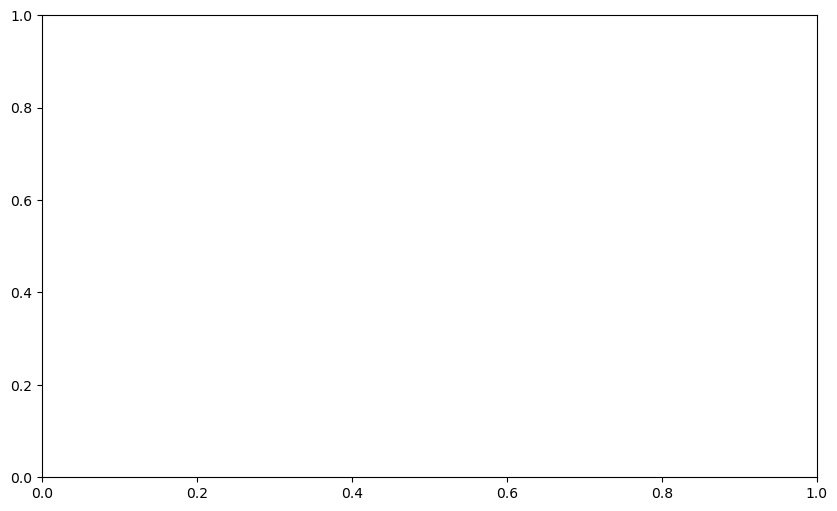

In [166]:
fig, ax = plt.subplots(figsize=(10, 6)) # Для некоторых случаев лучше смотреть без скользящего, для некоторых с ним, окно тоже
#стоит выставлять разное


for  data in others:
    ax.scatter(data['date'], data['impressions'])


ax.set_xlabel('Date')
ax.set_ylabel('Impressions')
ax.set_title('Scatter Plot of Impressions for Each Campaign')


ax.legend()


plt.show()

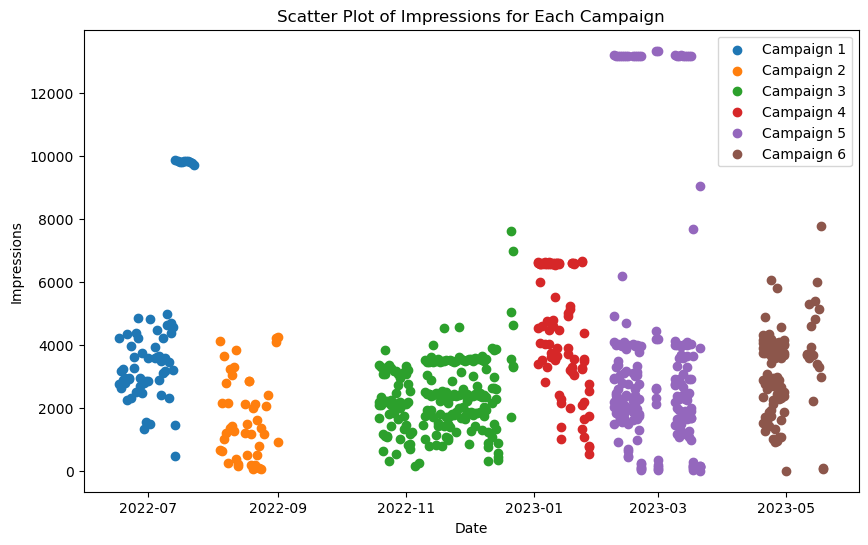

In [125]:
fig, ax = plt.subplots(figsize=(10, 6)) # Для некоторых случаев лучше смотреть без скользящего, для некоторых с ним, окно тоже
#стоит выставлять разное


for campaign_number, data in dexo_pharmacy.groupby('campaign_number'):
    ax.scatter(data['date'], data['impressions'], label=f'Campaign {campaign_number}')


ax.set_xlabel('Date')
ax.set_ylabel('Impressions')
ax.set_title('Scatter Plot of Impressions for Each Campaign')


ax.legend()


plt.show()

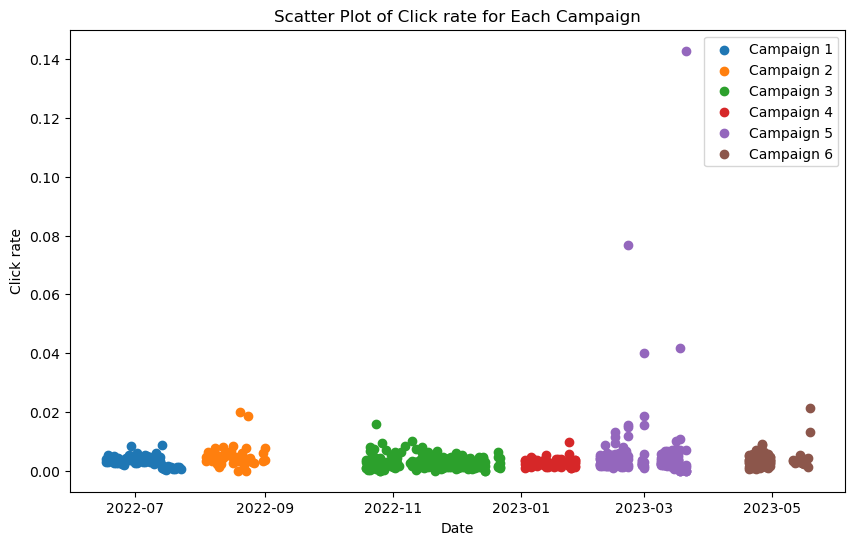

In [127]:
fig, ax = plt.subplots(figsize=(10, 6)) # Для некоторых случаев лучше смотреть без скользящего, для некоторых с ним, окно тоже
#стоит выставлять разное


for campaign_number, data in dexo_pharmacy.groupby('campaign_number'):
    ax.scatter(data['date'], data['click_rate'], label=f'Campaign {campaign_number}')


ax.set_xlabel('Date')
ax.set_ylabel('Click rate')
ax.set_title('Scatter Plot of Click rate for Each Campaign')


ax.legend()


plt.show()

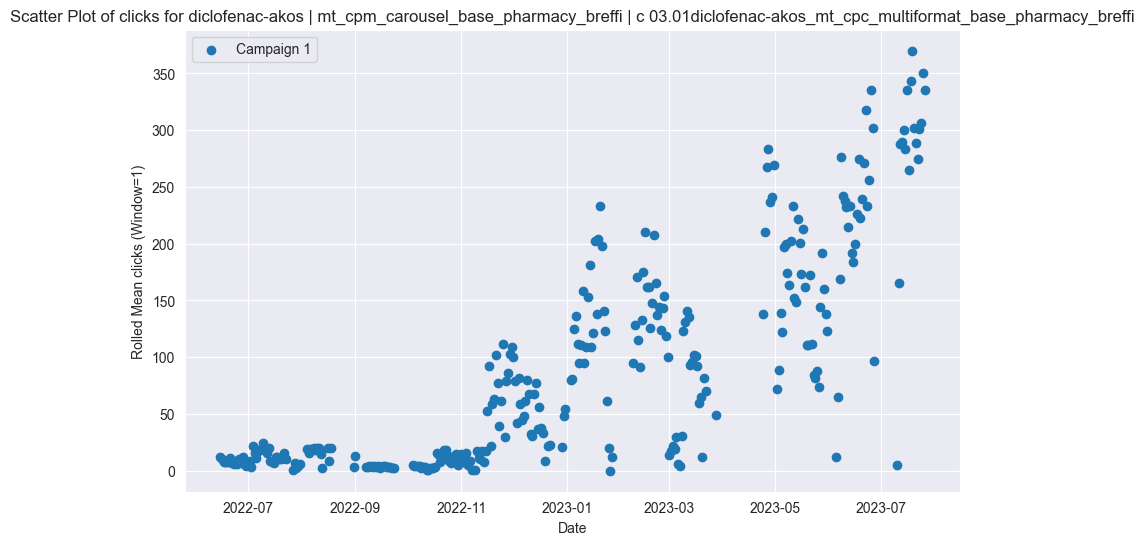

In [131]:
plot(diclo)

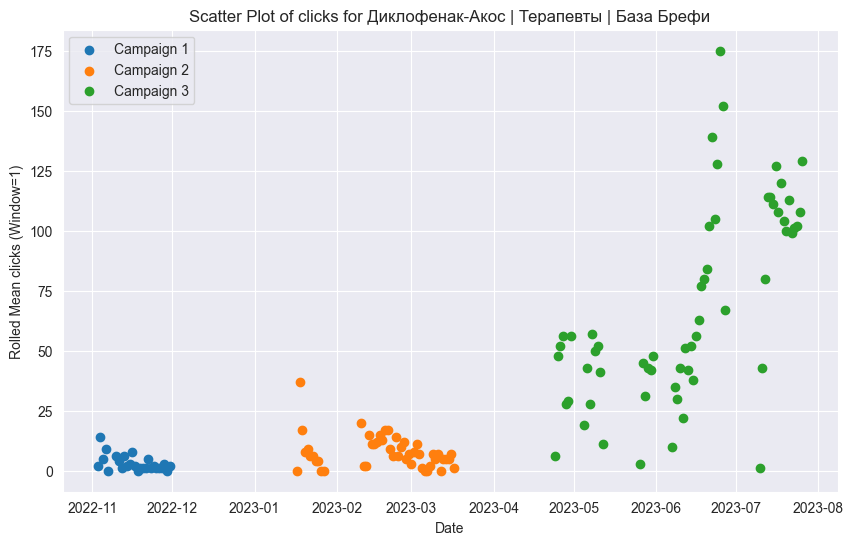

In [135]:
plot(diclo_thera)

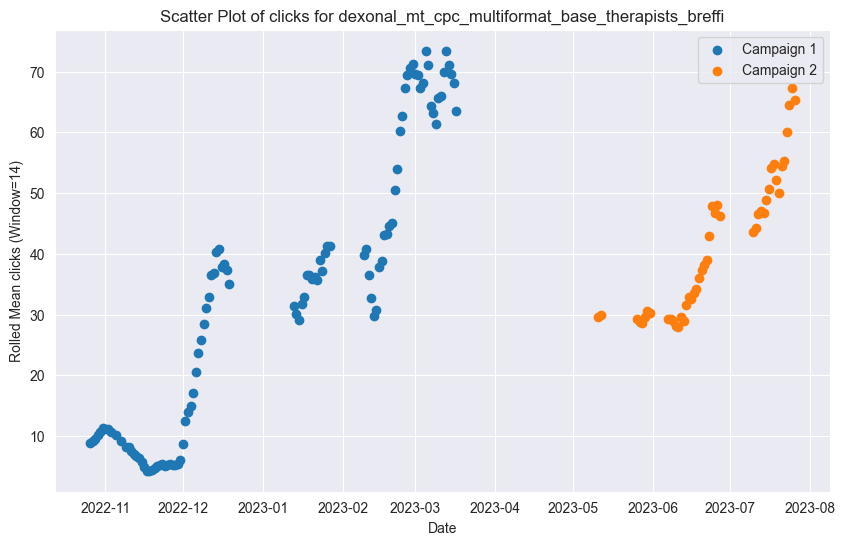

In [139]:
plot(dexo_thera, rolling_window=14)

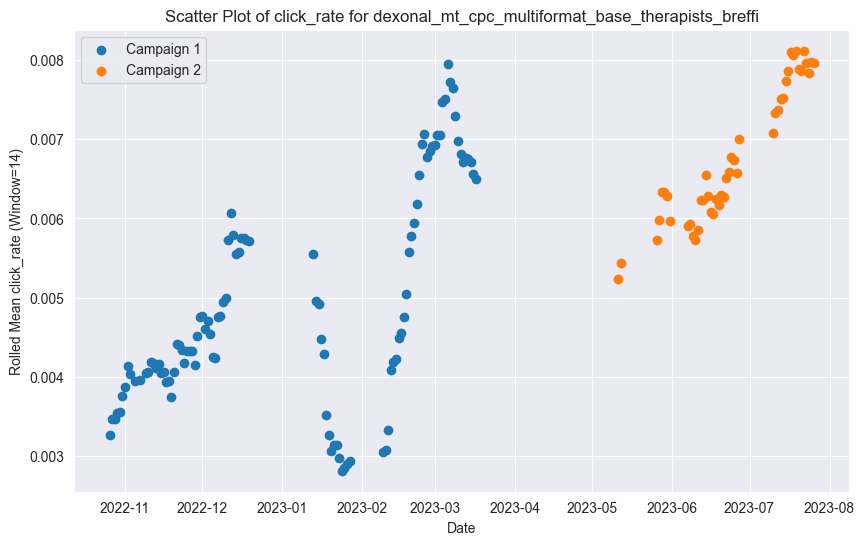

In [141]:
plot(dexo_thera, 'click_rate', rolling_window=14)

In [142]:
dexo_thera[(dexo_thera['campaign_name']=='Дексонал  | Терапевты | Баннеры | База Брефи')&(dexo_thera['impressions']>100)].sort_values(by='date').head()

,date,platform,campaign_name,impressions,clicks,click_rate,campaign_number
65,2023-01-13,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,731,2,0.002736,1
66,2023-01-14,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,12461,31,0.002488,1
67,2023-01-15,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,4759,20,0.004203,1
68,2023-01-16,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,29433,81,0.002752,1
69,2023-01-17,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,18819,59,0.003135,1


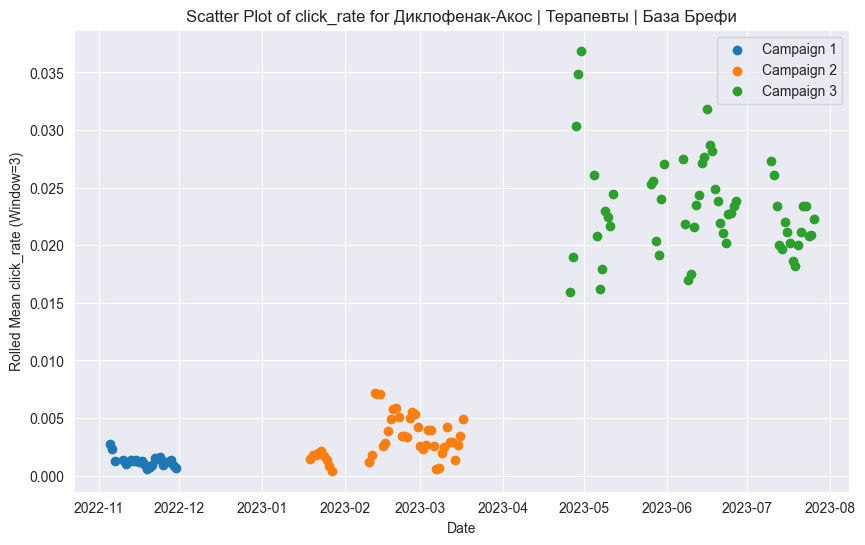

In [143]:
plot(diclo_thera, 'click_rate', rolling_window=3)

In [131]:
diclo_thera.groupby(['date','campaign_id'],as_index=False).sum()

,date,campaign_id,impressions,clicks,click_rate,campaign_number
0,2022-11-03,80102700,651,2,0.003072,1
1,2022-11-04,80102700,4423,14,0.003165,1
2,2022-11-05,80102700,2599,5,0.001924,1
3,2022-11-06,80102700,4887,9,0.001842,1
4,2022-11-07,80102700,327,0,0.000000,1
...,...,...,...,...,...,...
220,2023-07-24,86809161,8506,76,0.008935,9
221,2023-07-25,86809100,3326,38,0.011425,9
222,2023-07-25,86809161,4662,70,0.015015,9
223,2023-07-26,86809100,3648,45,0.012336,9


In [134]:
diclo_thera.head(50)

,platform,campaign_id,campaign_name,date,impressions,clicks,click_rate,campaign_number
65241,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-03,651,2,0.003072,1
65404,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-04,4423,14,0.003165,1
65721,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-05,2599,5,0.001924,1
65884,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-06,4887,9,0.001842,1
66354,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-07,327,0,0.000000,1
1507,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-10,2593,6,0.002314,2
2833,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-11,5037,4,0.000794,2
4452,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-12,2541,1,0.000394,2
5941,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-13,2057,6,0.002917,2
7224,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-14,4194,2,0.000477,2


In [118]:
diclo_thera.campaign_name.value_counts()

СВ003 | Диклофенак-Акос | Терапевты | Баннеры | База Breffi    59
СВ003 | Диклофенак-Акос | Терапевты | Баннеры | База БФГ       57
Диклофенак-Акос | Терапевты | Баннеры | База Брефи             47
Диклофенак-Акос | Терапевты | Баннеры | База БФГ               36
Диклофенак-Акос | Терапевты | База Брефи                       26
Name: campaign_name, dtype: int64

In [119]:
df

,platform,campaign_id,campaign_name,date,impressions,clicks,click_rate
0,yandex direct,75993195,Венарус | Фармацевты | Баннеры | База Брефи,2023-04-23,35423,109,0.003077
1,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,2023-04-23,13654,159,0.011645
2,yandex direct,82468420,Венарус | Фармацевты | Баннеры | База БФГ,2023-04-23,20100,58,0.002886
3,yandex direct,82469257,Дексонал | Фармацевты | Баннеры | База БФГ,2023-04-23,3459,31,0.008962
4,yandex direct,84389757,"ВА036 | Венарус, Венапрокт | Хирурги, проктоло...",2023-04-23,4061,29,0.007141
...,...,...,...,...,...,...,...
91922,my target,56531009,diclofenac-akos_mt_cpc_multiformat_base_neurol...,2022-07-31,741,6,0.008097
91936,my target,58007934,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,962,4,0.004158
91937,my target,58008074,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,175,1,0.005714
91938,my target,58008562,venarus_angiorus_mt_cpm_carousel_base_pharmacy...,2022-07-31,21167,27,0.001276


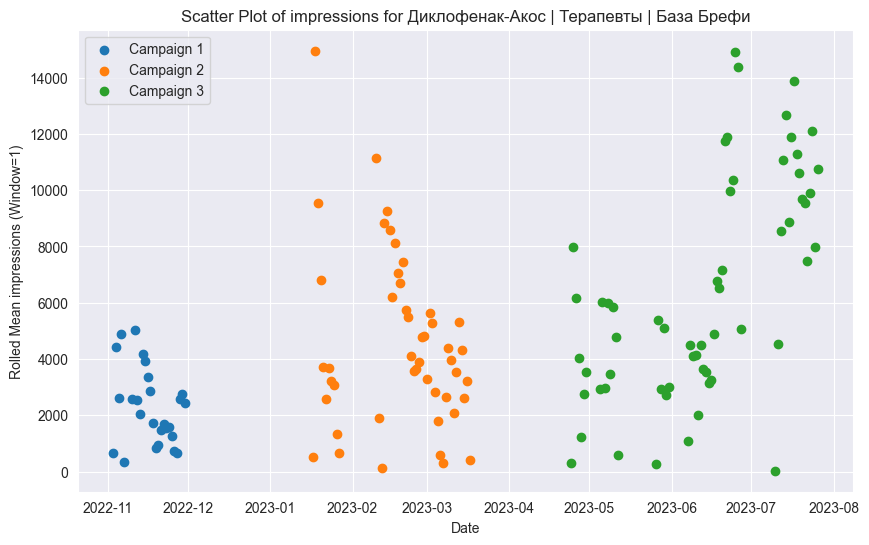

In [144]:
plot(diclo_thera, 'impressions', rolling_window=1)

In [147]:
diclo_thera.groupby('campaign_number').head().click_rate.mean()

0.00675615287648682

In [151]:
diclo_thera.groupby('campaign_number').apply(lambda group: group.head(5)['click_rate'].mean())

campaign_number
1    0.002001
2    0.001379
3    0.001570
4    0.004300
5    0.009578
6    0.007997
7    0.010804
8    0.009143
9    0.014032
dtype: float64

In [148]:
diclo_thera.groupby('campaign_number').tail().click_rate.mean()

0.008421424009779003

In [171]:
diclo.groupby('campaign_number').apply(lambda group: group.head(5)['click_rate'].mean()).mean()

0.004564235645679865

In [172]:
diclo.groupby('campaign_number').apply(lambda group: group.tail(5)['click_rate'].mean()).mean()

0.004190880889842965

In [174]:
dexo.groupby('campaign_number').apply(lambda group: group.head(5)['click_rate'].mean()).mean()

0.003514605516021033

In [173]:
dexo.groupby('campaign_number').apply(lambda group: group.tail(5)['click_rate'].mean()).mean()

0.00438462347104577

In [146]:
plot_rolled_mean(diclo, 'click_rate', window_size=1)

TypeError: plot() got an unexpected keyword argument 'window_size'

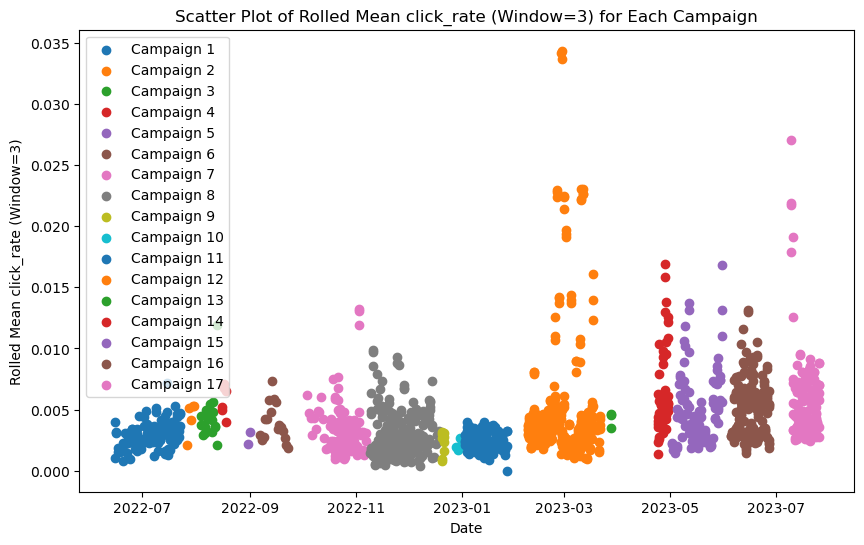

In [160]:
plot_rolled_mean(diclo[diclo['click_rate'] <0.1], 'click_rate', window_size=3)

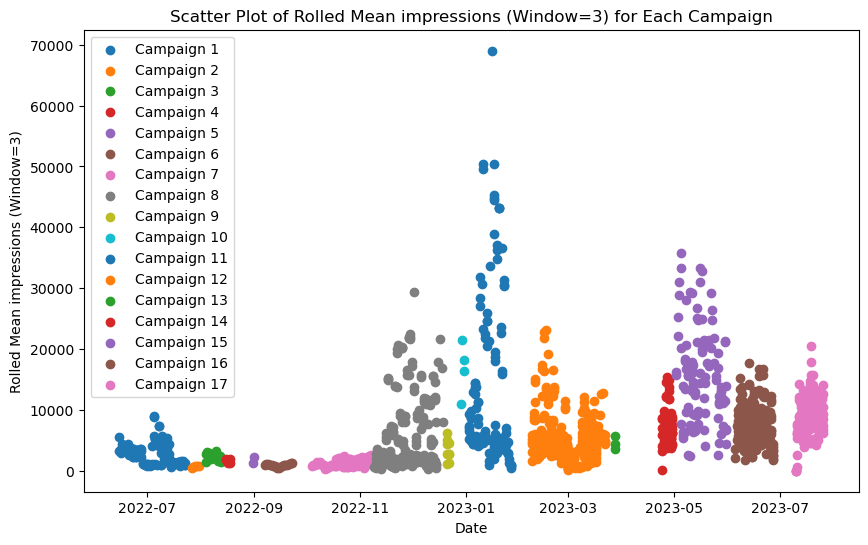

In [192]:
plot_rolled_mean(diclo, 'impressions', window_size=3)#Гипотеза: как соотносится большое(от 15-20к) кол-во показов и клик рейт 

In [99]:
#rolled_th_1 = dexo_thera[(dexo_thera['campaign_name']=='Дексонал  | Терапевты | Баннеры | База Брефи')&(dexo_thera['impressions']>100)].sort_values(by='date').rolling(window=7).mean().reset_index()
#sns.scatterplot(data = dexo_thera[(dexo_thera['campaign_name']=='dexonal_mt_cpc_multiformat_base_therapists_breffi')&(dexo_thera['impressions']>100)].sort_values(by='date'), x ='date',y='click_rate')

In [87]:
#dexo_thera[(dexo_thera['campaign_name']=='dexonal_mt_cpc_multiformat_base_therapists_breffi')&(dexo_thera['impressions']>100)].sort_values(by='impressions')

In [88]:
#sns.scatterplot(data = dexo_thera[(dexo_thera['campaign_name']=='dexonal_mt_cpc_multiformat_base_therapists_breffi')&(dexo_thera['impressions']>100)].sort_values(by='date'), x ='date',y='impressions')

In [89]:
#df.loc[((df.campaign_name.str.contains('dexonal')) | (df.campaign_name.str.contains('Дексонал'))) &((df.campaign_name.str.contains('therapist')) | (df.campaign_name.str.contains('Терапевт'))),'campaign_name'] = 'Дексонал  | Терапевты'

In [90]:
#df[df['campaign_name']=='Дексонал  | Терапевты']

In [191]:
df.campaign_name.unique()

array(['Венарус | Фармацевты | Баннеры | База Брефи',
       'Дексонал | Фармацевты | Баннеры | База Брефи',
       'Венарус | Фармацевты | Баннеры | База БФГ',
       'Дексонал | Фармацевты | Баннеры | База БФГ',
       'ВА036 | Венарус, Венапрокт | Хирурги, проктологи, колопроктологи | Баннеры | База Брефи',
       'ВА036 | Венарус, Венапрокт | Сосудистые хирурги, флебологи | Баннеры | База Брефи',
       'Максилак | Педиатры | Баннеры | База БФГ',
       'Максилак | Педиатры | Баннеры | База Бреффи',
       'ЕВ040_Акнауцер | Фармацевты | Баннеры | База БФГ',
       'СВ001 | Необутин | Гастро | Баннеры gif | База БФГ',
       'СВ001 | Необутин | Гастро | Баннеры gif | База Breffi',
       'Необутин | Гастро | Баннеры | База Брефи',
       'Кагоцел | Фармацевты | Баннеры | База Брефи',
       'Диклофенак-Акос | Терапевты | Баннеры | База Брефи',
       'Дексонал  | Терапевты | Баннеры | База Брефи',
       'Диклофенак-Акос | Фармацевты | Баннеры | База Брефи',
       'Кагоцел, Эльмуци

In [ ]:
def add_campaign_numbers_modified(df): #Что-то я тут явно напутал
    
    df['date'] = pd.to_datetime(df['date'])

   
    df = df.sort_values(['date', 'campaign_id'])

    
    current_campaign = 0
    previous_date = None
    previous_campaign_ids = set()

    
    campaign_numbers = []

    # Iterate through the sorted dates
    for date, campaign_id in zip(df['date'], df['campaign_id']):
        if previous_date is None or (date - previous_date).days > 1:
            current_campaign += 1
            previous_campaign_ids.clear()  
        elif campaign_id not in previous_campaign_ids:
            current_campaign += 1
            previous_campaign_ids.clear()  
        
        campaign_numbers.append(current_campaign)
        previous_date = date
        previous_campaign_ids.add(campaign_id)

    
    df['campaign_number'] = campaign_numbers
    
    return df